**Goal** of the task is to **predict SalePrice** by creating and training a model minimizing the **RMSE**.

    For each Id(house) in the test set, model must predict the value of the SalePrice variable. 



## Libraries

In [4]:
import pandas as pd
from IPython.display import Image
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as normal
from scipy.stats import skew,kurtosis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore') 
import pylab 
from matplotlib import colors as mcolors
import random
import seaborn as sns

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

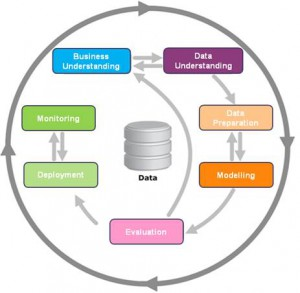

In [2558]:
Image(filename='crisp-dm.jpg')

Using the CRISP-DM methodology our main focus will be on the following phases:

    - Data Understanding
    - Data Preparation
    - Modelling
    - Evaluation

# Data Preparation (Data Tidying)

In [0]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

In [0]:
#store Id for the submission file and remove it from the train and test data cause it is irrelevant for the prediction model
Id=test_data['Id']

Drop column 'Id' cause we don't need it for training the model!

In [0]:
train_data.drop(['Id'],axis=1,inplace=True)

In [0]:
test_data.drop(['Id'],axis=1,inplace=True)

Train data has 1460 records and 80 attributes, while test data has 1459 records and 79 attributes when removing Id column.

In [2563]:
train_data.shape

(1460, 80)

In [2564]:
test_data.shape

(1459, 79)

In [0]:
houses_data = train_data.append(test_data,ignore_index=True)

**MERGE** train data and test data into one dataframe so we can preform imputing of the NaN values and feature creation

Now the whole dataset (with train and test data has 2919 rows)

In [2566]:
houses_data.shape

(2919, 80)

In [2567]:
houses_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,208500.0,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,181500.0,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,223500.0,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,140000.0,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,250000.0,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Importing `data_preparation.py` module and its functions

In [0]:
import data_preparation as dp #importing data_preparation.py file

#### Transforming numerical into categorical variable

MSSubClass is the building class and categorical variable.

In [2569]:
from importlib import reload 
reload(dp)#reloading in case of any change of the file

<module 'data_preparation' from '/content/data_preparation.py'>

In [2570]:
#this column should be categorical and not numerical
col_names=['MSSubClass']
[dp.number_unique_col(houses_data,col) for col in col_names]

['Number of unique values for MSSubClass :16']

In [2571]:
houses_data.MSSubClass.dtype #before method

dtype('int64')

In [0]:
houses_data=dp.convert_to_categorical(houses_data,col_names)#calling method convert_to_categorical from the module

In [2573]:
houses_data.MSSubClass.dtype #after method --> checking if method worked

dtype('O')

There are different ways to handle the missing values(**NaN** values). The first one is to **drop the columns** with missing values. The second one is to **drop the rows** with the missing values, and third is to **impute** those missing values.

## Target Variable

The analysis of the variable we need to predict

In [2574]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

House prices range from 34 900 to 755 000. The median value is 163 000.

In [2575]:
print('kurtosis',kurtosis(train_data.SalePrice),'skewness',
skew(train_data.SalePrice)) 

kurtosis 6.509812011089439 skewness 1.880940746034036


The distribution of the target variable is positively skewed.

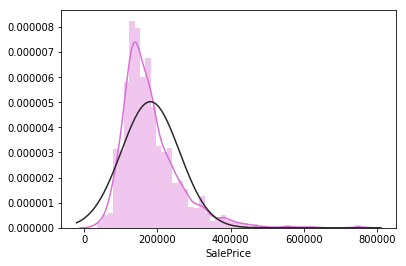

In [2576]:
sns.distplot(train_data.SalePrice,color="orchid",fit=normal)

"Multiple regression works most reliably when the target variable is aproximately **normally distributed** ."

As we can see in the graph above, it is not fitting the normal distribution so we need to transform it by taking a log of its value plus 1 (Plus 1 is added to prevent cases when value is 0 and log from 0 is undefined).

After the log transformation we can see that transformed value of SalePrice is now closer to the normal probability distribution function.

We will first perform the log-transform of the target variable in order to improve the linearity of the data. Afterwards, predictions of the final model should be converted to their original form.

### Transforming the dependent(target) variable

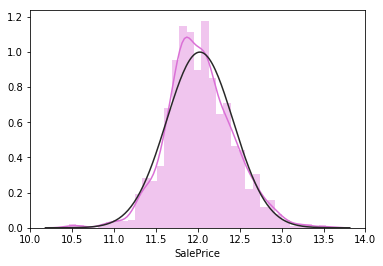

In [2577]:
sns.distplot(np.log1p(train_data.SalePrice),color="orchid",fit=normal)

In [0]:
houses_data.SalePrice=np.log1p(houses_data.SalePrice)#log1p is used cause log of 0 is not defined, goes to minus infinity

Just for the part of test_data since we are filling the NAN values for merged dataframe(train_data+test_data)

In [0]:
houses_data.SalePrice=houses_data.SalePrice.fillna(0) 

### Imputing missing values


In [2580]:
#Check frequency of NaN values
is_null_cols=houses_data.isnull()
a=(is_null_cols.sum()/len(is_null_cols)*100).sort_values(axis=0, ascending=False) 
a[a.apply(lambda x: x>0)]

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Utilities        0.068517
Electrical       0.034258
KitchenQual      0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
GarageCars       0.034258
GarageArea       0.034258
TotalBsmtSF      0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
SaleType         0.034258
dtype: float64

Text(0.5, 1.0, 'Attributes with NAN values')

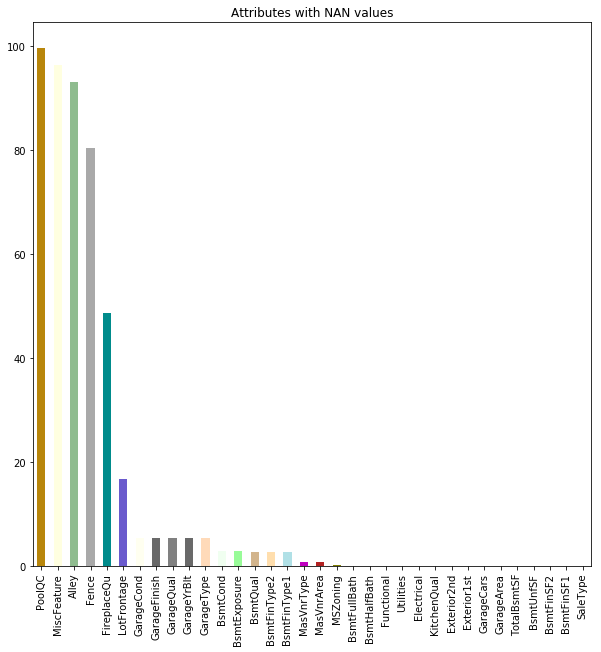

In [2581]:
nan_df=a[a.apply(lambda x: x>0)]
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS) #list of colors
cols=random.sample(list(colors.keys()),len(nan_df)) #take random color sample from colors list->length of sample is number of accepted configurations

plt.figure(figsize=(10, 10))
nan_df.plot(kind = "bar",colors=cols)
plt.title("Attributes with NAN values")

In [2582]:
nan_df[nan_df>48].index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], dtype='object')

Removing attributes with a number of NaN values **> 48%**

In [0]:
drop_cols=nan_df[nan_df>48].index
houses_data.drop(drop_cols,axis=1,inplace=True)

#### Number of NaN values for the rest of the columns

In [2584]:
x=houses_data.isnull().sum()
x[x>0].sort_values(ascending=False)

LotFrontage     486
GarageYrBlt     159
GarageQual      159
GarageFinish    159
GarageCond      159
GarageType      157
BsmtCond         82
BsmtExposure     82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
MasVnrArea       23
MSZoning          4
BsmtFullBath      2
BsmtHalfBath      2
Utilities         2
Functional        2
Exterior1st       1
Electrical        1
BsmtUnfSF         1
Exterior2nd       1
TotalBsmtSF       1
GarageCars        1
KitchenQual       1
BsmtFinSF2        1
BsmtFinSF1        1
SaleType          1
GarageArea        1
dtype: int64

In [0]:
'''
fill_with_zero - fills NaNs with 0
fill_with_none - fills NaNs with 'None'
'''
zero_cols=["GarageCars","GarageArea","GarageYrBlt",'MasVnrArea',
           'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
           'BsmtFullBath', 'BsmtHalfBath']
houses_data=dp.fill_with_zero(houses_data,zero_cols)

none_cols=["BsmtQual","BsmtCond","GarageFinish",'GarageQual',
           "BsmtExposure","BsmtFinType1","BsmtFinType2",
           "GarageType","GarageCond",'MasVnrType']
houses_data=dp.fill_with_none(houses_data,none_cols)

**GarageYrBlt, GarageCars, GarageArea**      

Context in which information is used is very important. If NaN in the column GarageArea is replaced with 0, it means that there is **NO garage** therefore it is not possible that year of building (GarageYrBlt) exists. 
In other words:
    if GarageArea is 0; GarageCars and GarageYrBlt must be also.

In [2586]:
np.unique(houses_data.iloc[np.where((houses_data.GarageArea==0))].loc[:,['GarageYrBlt','GarageCars']])

array([0.])

In [0]:
# Columns whose NaN values will be imputed with the most frequent values in the same column
top_cols=['Electrical','Exterior1st','Exterior2nd','KitchenQual','SaleType','MSZoning',"Functional"]
houses_data=dp.fill_top(houses_data,top_cols)

Change described quality grade to numbers

     {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

In [0]:
houses_data.LotFrontage.fillna(np.mean(houses_data.LotFrontage),inplace=True)

In [0]:
qual_cols=['ExterQual','ExterCond','BsmtQual','BsmtCond','KitchenQual','GarageQual','GarageCond',\
          'HeatingQC']
for qc in qual_cols:
    dp.mapping_dict(qc,houses_data)

In [0]:
houses_data["BsmtExposure"] = houses_data["BsmtExposure"].map({'None': 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

In [0]:
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
houses_data = houses_data.drop(['Utilities'], axis=1)

# Data Preparation (Feature engineering)

In [2592]:
#Check are there still any NaN values left
houses_data.isna().sum().sum()

0

In [2593]:
#Check for some important numerical features
x=train_data.shape[0]
train_data=houses_data.select_dtypes(exclude=['object'])[:x]

y=train_data.SalePrice
x=train_data.drop(['SalePrice'],axis=1)

x_train=x
y_train=y

#Features importance via featureSelection library
estimator  = Lasso()
featureSelection = SelectFromModel(estimator)
featureSelection.fit(x_train, y_train)

selectedFeatures = featureSelection.transform(x_train)
selectedFeatures

relevant_features=x_train.columns[featureSelection.get_support()]
relevant_features

Index(['2ndFlrSF', 'BsmtFinSF1', 'GarageArea', 'GarageYrBlt', 'GrLivArea',
       'MasVnrArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')

We can see some of the important numerical features using a method **SelectFromModel** from the featureSelection library.

This method is a meta-transformer for selecting features and it is based on importance weights.

Additionally, we created new attributes:

**TotalSuperficial**

               TotalSuperficial = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
**TotalBsmtBath**

                TotalBsmtBath = BsmtFullBath + BsmtHalfBath

After creating the above mentioned features we dropped the features used to derive them.

In [0]:
houses_data['TotalSuperficial'] = houses_data['TotalBsmtSF'] + houses_data['1stFlrSF'] + houses_data['2ndFlrSF']

houses_data['TotalBsmtBath'] = houses_data['BsmtFullBath'] + houses_data['BsmtHalfBath']

to_drop=['TotalBsmtSF','1stFlrSF','2ndFlrSF','BsmtFullBath','BsmtHalfBath']
houses_data=houses_data.drop(to_drop,axis=1)

**Mutual information (MI)** between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [0]:
x=train_data.shape[0]
train_data=houses_data.select_dtypes(exclude=['object'])[:x] 

y=train_data.SalePrice
x=train_data.drop(['SalePrice'],axis=1)

x_train=x
y_train=y

mi_df2=pd.DataFrame()
mi_df2['cols']=pd.Series(x.columns)
mi_df2['MI']=pd.Series(mutual_info_regression(x,y))
mi_df2['MI']=mi_df2['MI'].apply(lambda x:round(x,3))

From the table below we can see the expected results that numerical features which are the most significant ones for predicting SalePrice are TotalSuperficial, OverallQual, GrLivArea, YearBuilt.

In [2596]:
mi_df2.sort_values('MI',ascending=False)[:10] #top ten

,cols,MI
39,TotalSuperficial,0.684
31,OverallQual,0.558
18,GrLivArea,0.458
36,YearBuilt,0.362
13,GarageArea,0.361
14,GarageCars,0.360
22,KitchenQual,0.340
10,ExterQual,0.335
6,BsmtQual,0.326
12,FullBath,0.263


In [2597]:
data_copy=houses_data.copy().select_dtypes(exclude=['object']) 

all_cols=data_copy.columns
value_percentage_n=pd.DataFrame()
percentage=[]
num_of_rows=data_copy.shape[0]
# Calculating the percentage of repeated values in the column for numerical variables
for col in all_cols:
    percentage.append((np.max(data_copy[col].value_counts()))/num_of_rows)
value_percentage_n['column']=all_cols
value_percentage_n['percentage']=percentage
 

mi_vals=[]

y=houses_data.SalePrice
x=data_copy

x_train=x
y_train=y

# Calculating MI (mutual information) for numerical variables
mi_df=pd.DataFrame()
mi_df['cols']=pd.Series(x.columns)
mi_df['MI']=pd.Series(mutual_info_regression(x,y))
mi_df['MI']=mi_df['MI'].apply(lambda x:round(x,3))

for c in all_cols:
    mi_vals.append(mi_df[mi_df.cols==c].MI.values)
value_percentage_n['MI']=mi_vals  
value_percentage_n.sort_values('percentage',ascending=False)[:10]

,column,percentage,MI
32,PoolArea,0.995546,[0.0]
0,3SsnPorch,0.987324,[0.0]
25,LowQualFinSF,0.986297,[0.009]
27,MiscVal,0.964714,[0.0]
21,KitchenAbvGr,0.954094,[0.005]
34,ScreenPorch,0.912299,[0.0]
15,GarageCond,0.909215,[0.03]
2,BsmtCond,0.892771,[0.022]
16,GarageQual,0.892086,[0.05]
5,BsmtFinSF2,0.881124,[0.003]


In [2598]:
houses_data.corr().SalePrice.abs().sort_values(ascending=False)

SalePrice           1.000000
TotRmsAbvGrd        0.060575
LotArea             0.054992
GrLivArea           0.053188
TotalSuperficial    0.050609
YearRemodAdd        0.047303
MoSold              0.041959
Fireplaces          0.040783
LotFrontage         0.040212
BsmtCond            0.037371
3SsnPorch           0.034153
OverallQual         0.033856
BsmtQual            0.032449
GarageQual          0.025175
MasVnrArea          0.023926
GarageCars          0.023594
KitchenQual         0.023500
LowQualFinSF        0.023454
GarageArea          0.022663
BsmtUnfSF           0.022546
EnclosedPorch       0.022505
ExterQual           0.020876
YearBuilt           0.017921
BsmtExposure        0.017707
BsmtFinSF2          0.017664
BsmtFinSF1          0.017550
PoolArea            0.016820
YrSold              0.016244
HalfBath            0.015604
WoodDeckSF          0.015205
BedroomAbvGr        0.014424
FullBath            0.014357
ScreenPorch         0.013822
MiscVal             0.013504
GarageCond    

In [2600]:
data_copy=houses_data.copy().select_dtypes(include=['object']) 

all_cols=data_copy.columns
value_percentage_c=pd.DataFrame()
percentage=[]
num_of_rows=data_copy.shape[0]

# Calculating the percentage of repeated values in the column for categorical variables
for col in all_cols:
    percentage.append((np.max(data_copy[col].value_counts()))/num_of_rows)
value_percentage_c['column']=all_cols
value_percentage_c['percentage']=percentage
value_percentage_c.sort_values(['percentage'],ascending=False)[:10]

,column,percentage
28,Street,0.995889
5,Condition2,0.989723
24,RoofMatl,0.985269
13,Heating,0.984584
16,LandSlope,0.951696
3,CentralAir,0.932854
10,Functional,0.931483
6,Electrical,0.915382
23,PavedDrive,0.904762
15,LandContour,0.898253


In [2601]:
#Linear dependency
houses_data.corr().SalePrice.abs().sort_values(ascending=True)

OpenPorchSF         0.001780
ExterCond           0.004051
KitchenAbvGr        0.004475
TotalBsmtBath       0.007362
GarageYrBlt         0.008073
OverallCond         0.008443
HeatingQC           0.008901
GarageCond          0.012048
MiscVal             0.013504
ScreenPorch         0.013822
FullBath            0.014357
BedroomAbvGr        0.014424
WoodDeckSF          0.015205
HalfBath            0.015604
YrSold              0.016244
PoolArea            0.016820
BsmtFinSF1          0.017550
BsmtFinSF2          0.017664
BsmtExposure        0.017707
YearBuilt           0.017921
ExterQual           0.020876
EnclosedPorch       0.022505
BsmtUnfSF           0.022546
GarageArea          0.022663
LowQualFinSF        0.023454
KitchenQual         0.023500
GarageCars          0.023594
MasVnrArea          0.023926
GarageQual          0.025175
BsmtQual            0.032449
OverallQual         0.033856
3SsnPorch           0.034153
BsmtCond            0.037371
LotFrontage         0.040212
Fireplaces    

In [2602]:
# The top 10 categorical variables with the most repeated values (for example in Street column 99% of records have the same value)
value_percentage_c.sort_values('percentage',ascending=False)[:10]

,column,percentage
28,Street,0.995889
5,Condition2,0.989723
24,RoofMatl,0.985269
13,Heating,0.984584
16,LandSlope,0.951696
3,CentralAir,0.932854
10,Functional,0.931483
6,Electrical,0.915382
23,PavedDrive,0.904762
15,LandContour,0.898253


In [2603]:
# The top 10 numerical variables with the most repeated values (for example in column PoorArea, 99% of records have the same value)
value_percentage_n.sort_values('percentage',ascending=False)[:10]

,column,percentage,MI
32,PoolArea,0.995546,[0.0]
0,3SsnPorch,0.987324,[0.0]
25,LowQualFinSF,0.986297,[0.009]
27,MiscVal,0.964714,[0.0]
21,KitchenAbvGr,0.954094,[0.005]
34,ScreenPorch,0.912299,[0.0]
15,GarageCond,0.909215,[0.03]
2,BsmtCond,0.892771,[0.022]
16,GarageQual,0.892086,[0.05]
5,BsmtFinSF2,0.881124,[0.003]


We dropped the columns which have the same values in the majority of rows (more or equal than 90%).

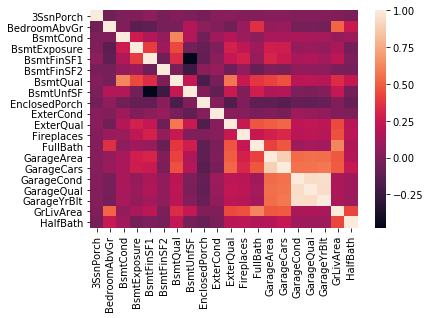

In [2604]:
cc=houses_data.select_dtypes(exclude=['object']).iloc[:,:20].corr()
sns.heatmap(cc)

In [0]:
remove_cols=['Condition2','RoofMatl','LandSlope','Functional','Electrical','LandContour',
             'Heating','CentralAir'] #except for the 'Street'
houses_data.drop(remove_cols,axis=1,inplace=True)

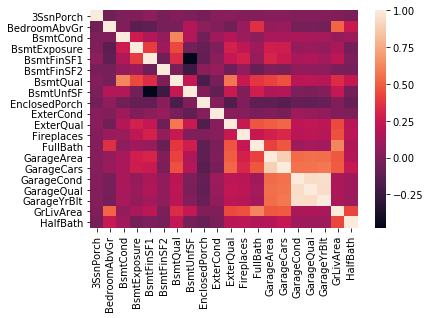

In [2606]:
cc=houses_data.select_dtypes(exclude=['object']).iloc[:,:20].corr()
sns.heatmap(cc)

In [2607]:
houses_data.corr().GarageCond.abs().sort_values(ascending=False)[:7]

GarageCond     1.000000
GarageYrBlt    0.949602
GarageQual     0.946656
GarageCars     0.556232
GarageArea     0.539521
OverallQual    0.289864
YearBuilt      0.278153
Name: GarageCond, dtype: float64

In [2608]:
len(houses_data.GarageCond==houses_data.GarageQual)

2919

Since GarageCond and GarageQual are highly correlated and almost always have the same value, we removed one in order to prevent multicolinearity issues.
We will remove GarageCond.

In [2609]:
houses_data.GarageFinish.value_counts()

Unf     1230
RFn      811
Fin      719
None     159
Name: GarageFinish, dtype: int64

In [0]:
drop_garage_mc=['GarageCond','GarageFinish']
houses_data.drop(drop_garage_mc,axis=1,inplace=True)

In [2611]:
houses_data.shape

(2919, 61)

In [2612]:
houses_data.corr().GarageCars.abs().sort_values(ascending=False)[:7] #GarageCars: Size of garage in car capacity

GarageCars          1.000000
GarageArea          0.889890
OverallQual         0.600743
GarageYrBlt         0.580432
GarageQual          0.566567
TotalSuperficial    0.551298
YearBuilt           0.538611
Name: GarageCars, dtype: float64

Index(['YearRemodAdd', 'YearBuilt', 'BsmtQual', 'TotalSuperficial',
       'HeatingQC', 'GarageCars', 'GarageArea', 'FullBath', 'GrLivArea',
       'MasVnrArea', 'BsmtExposure', 'OpenPorchSF', 'TotRmsAbvGrd',
       'BsmtUnfSF', 'Fireplaces', 'BsmtFinSF1', 'GarageQual', 'WoodDeckSF',
       'GarageYrBlt', 'HalfBath', 'BsmtCond', 'EnclosedPorch', 'LotFrontage',
       'OverallCond', 'KitchenAbvGr', 'TotalBsmtBath', 'LowQualFinSF',
       'LotArea', 'BsmtFinSF2', 'BedroomAbvGr', '3SsnPorch', 'ExterCond',
       'MoSold', 'PoolArea', 'SalePrice', 'MiscVal', 'YrSold', 'ScreenPorch'],
      dtype='object')

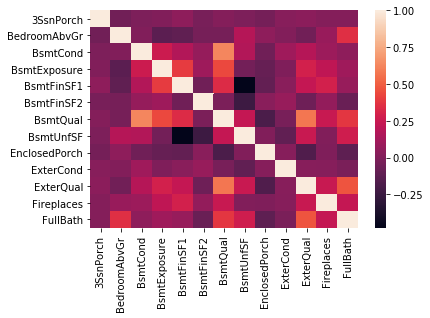

In [2613]:
#Remove multicolinearity
cc=houses_data.iloc[:,:20].corr()
sns.heatmap(cc)
additional_drops=houses_data.corr().ExterQual.abs().sort_values(ascending=False)[2:].index[1:]
additional_drops

#houses_data.drop(additional_drops,axis=1,inplace=True)

In [2614]:
print('BsmtCond')
print('MI',mi_df2[mi_df2.cols=='BsmtCond'].MI.values)
print('Percentage',value_percentage_n[value_percentage_n.column=='BsmtCond'].percentage.values)

BsmtCond
MI [0.048]
Percentage [0.8927715]


We decided to eliminate **BsmtCond** cause it has low MI value and high percentage rate (of the most frequent column).

$n_{mf}$=number of instances of the most frequent category

N=number of instances in data

percentage=$\frac {n_{mf}}{N}$



Additional categorical columns that we decided to drop which improve the score of the model and minimize the RMSE more than the model with them.

In [2615]:
cat_drop=['Foundation','LotConfig','Exterior1st','Exterior2nd',
     'MSZoning','RoofStyle']#, 'GarageFinish'
#cat_drop=houses_data.select_dtypes(include=[object]).columns
cat_dummies=pd.get_dummies(houses_data.loc[:,cat_drop])
    
x=train_data.shape[0]
train_data_cd=cat_dummies[:x] 

y=train_data.SalePrice
x=train_data_cd

x_train=x
y_train=y

mi_df_cat_dm=pd.DataFrame()
mi_df_cat_dm['cols']=pd.Series(x.columns)
mi_df_cat_dm['MI']=pd.Series(mutual_info_regression(x,y))
mi_df_cat_dm['MI']=mi_df_cat_dm['MI'].apply(lambda x:round(x,3))
mi_dict={}
mx_dict={}
for c in cat_drop:
    val=0
    cnt=0
    mx=[]

    for col in mi_df_cat_dm.iterrows():
        if str.startswith(col[1].cols,c):
            val+=col[1].MI
            cnt+=1
            mx.append(val)
    mx_dict[c]=round(np.min(mx),3)
    mi_dict[c]=round((val/cnt),3)  
    
for cd in cat_drop:
    print('\033[1m',cd,"\033[0;0m",'Percentage',value_percentage_c[value_percentage_c.column==cd].percentage.values\
         ,'avg_MI',[mi_dict[cd]],'MIN MI',mx_dict[cd])
    print('-------------------------------------------------------')
    


 Foundation  Percentage [0.44809866] avg_MI [0.055] MIN MI 0.032
-------------------------------------------------------
 LotConfig  Percentage [0.7307297] avg_MI [0.006] MIN MI 0.0
-------------------------------------------------------
 Exterior1st  Percentage [0.35149024] avg_MI [0.011] MIN MI 0.009
-------------------------------------------------------
 Exterior2nd  Percentage [0.34772182] avg_MI [0.012] MIN MI 0.006
-------------------------------------------------------
 MSZoning  Percentage [0.777321] avg_MI [0.035] MIN MI 0.012
-------------------------------------------------------
 RoofStyle  Percentage [0.79136691] avg_MI [0.008] MIN MI 0.001
-------------------------------------------------------


In [2616]:
import operator
sorted(mi_dict.items(), key=operator.itemgetter(0))

[('Exterior1st', 0.011),
 ('Exterior2nd', 0.012),
 ('Foundation', 0.055),
 ('LotConfig', 0.006),
 ('MSZoning', 0.035),
 ('RoofStyle', 0.008)]

When we create dummy variables from these categorical variables we store which is the smallest MI value and calculate the AVG value of MI for original variables using their dummy variables.

In [0]:
houses_data.drop(cat_drop,axis=1,inplace=True)

In [2618]:
houses_data.corr().MasVnrArea.abs().sort_values(ascending=False)[:5]

MasVnrArea          1.000000
TotalSuperficial    0.470492
OverallQual         0.426528
GrLivArea           0.400088
GarageArea          0.371071
Name: MasVnrArea, dtype: float64

In [0]:
additional_drop=['MasVnrArea','TotRmsAbvGrd','BsmtCond','WoodDeckSF']
for ad in additional_drop:
  try:
    houses_data.drop(ad,axis=1,inplace=True)
  except:
    print(ad)
    continue

In [2620]:
houses_data.corr().YearBuilt.abs().sort_values(ascending=False)[:5]

YearBuilt       1.000000
BsmtQual        0.621369
YearRemodAdd    0.612235
ExterQual       0.605759
OverallQual     0.597554
Name: YearBuilt, dtype: float64

**YearBuilt** brings important information according to the FeatureSelection library. We see that it is highly correlated to the **BsmtQual** attribute. Therefore, we decided to remove **BsmtQual** from the data.

In [0]:
houses_data.drop(['BsmtQual'],axis=1,inplace=True)

In [2622]:
houses_data.corr().YearRemodAdd.abs().sort_values(ascending=False)[:5]

YearRemodAdd    1.000000
KitchenQual     0.613987
YearBuilt       0.612235
ExterQual       0.607421
OverallQual     0.571532
Name: YearRemodAdd, dtype: float64

**YearRemodAdd** brings important information according to the FeatureSelection library. We see that it is highly correlated to the **KitchenQual** attribute. Therefore, we decided to remove **KitchenQual** from the data.

In [0]:
houses_data.drop(['KitchenQual'],axis=1,inplace=True)

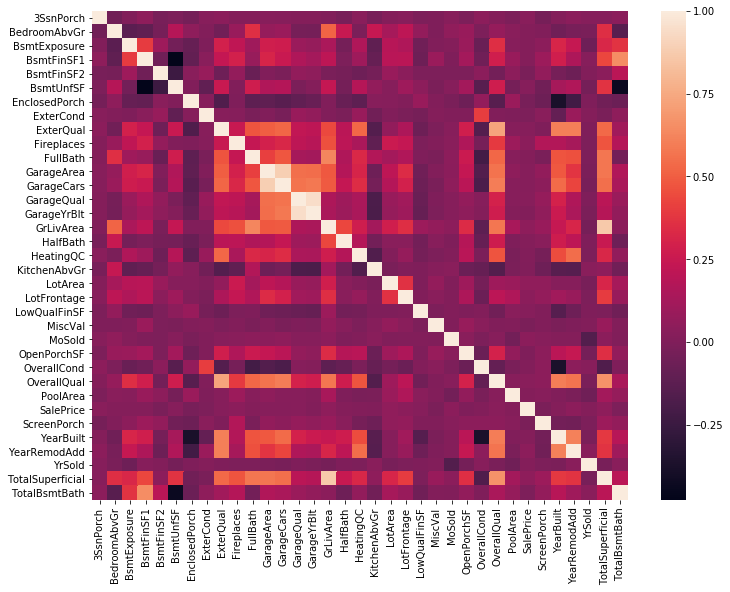

In [2624]:
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(houses_data.corr())

GarageArea and GarageCars are also highly correlated as we can see from the correlation matrix so we decided to drop GarageArea.

And LotFrontage is correlated to TotalSuperficial so we shall remove it also.

In [2625]:
houses_data.corr().LotFrontage.abs().sort_values(ascending=False)[:3]

LotFrontage         1.000000
TotalSuperficial    0.399965
LotArea             0.364382
Name: LotFrontage, dtype: float64

In [0]:
houses_data.drop(['GarageArea','LotFrontage'],axis=1,inplace=True)

In [2627]:
cats=houses_data.select_dtypes(include=['object']).columns
cats

Index(['BldgType', 'BsmtFinType1', 'BsmtFinType2', 'Condition1', 'GarageType',
       'HouseStyle', 'LotShape', 'MSSubClass', 'MasVnrType', 'Neighborhood',
       'PavedDrive', 'SaleCondition', 'SaleType', 'Street'],
      dtype='object')

In [0]:
#Creating dummy variables for categorical variables
dummies=pd.get_dummies(houses_data.select_dtypes(include=['object']))#, drop_first=True)
houses_data.drop(houses_data.select_dtypes(['object']).columns,axis=1,inplace=True)
houses_data = pd.concat([houses_data, dummies], axis=1)

In [0]:
#Take from the merged dataframe(train+test) separately the first dataframe - train_data and second one test_data
x=train_data.shape[0]

train_data=houses_data[:x]
test_data=houses_data[x:]

In [0]:
y=train_data.SalePrice
x=train_data.drop(['SalePrice'],axis=1)
mi_df=pd.DataFrame()
mi_df['cols']=pd.Series(x.columns)
mi_df['MI']=pd.Series(mutual_info_regression(x,y))
mi_df['MI']=mi_df['MI'].apply(lambda x:round(x,3))  

In [2631]:
mi_df.sort_values('MI',ascending=False)[:10]

,cols,MI
30,TotalSuperficial,0.686
24,OverallQual,0.566
14,GrLivArea,0.458
11,GarageCars,0.369
27,YearBuilt,0.369
8,ExterQual,0.324
10,FullBath,0.258
13,GarageYrBlt,0.257
28,YearRemodAdd,0.233
18,LotArea,0.170


### Detecting and removing outliers

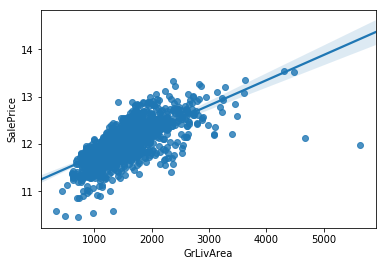

In [2632]:
sns.regplot(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.show()

In [0]:
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<13)].index)

#We noticed these two datapoints and we removed them with the above mentioned condition

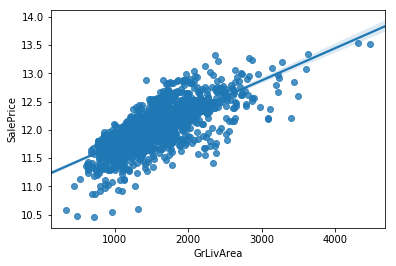

In [2634]:
sns.regplot(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.show()

In [0]:
### Preparing data for making a prediction

rmse_df=pd.DataFrame(columns=['Alg','RMSE'])
 

#train_data=train_data.sample(frac=1)#just to shuffle a bit

y=train_data.SalePrice
x=train_data.drop(['SalePrice'],axis=1)

x_train=x
y_train=y

test_data.drop('SalePrice',axis=1,inplace=True)

In [0]:
def root_mean_squared_error(mse):
    return np.sqrt(mse)

# Modelling

# Evaluation

After many ** trial and error ** tryouts we decided that out final model would be the following: 

          
      GradientBoosting*0.1+Lasso*0.1+Ridge*0.15+xgboost*0.25+StackingCVRegressor*0.4

whereby StackingCVRegressor is composed of:


    1.    regressors=(ridge, lasso, ENet, GBoost)
    2.    meta_regressor=ENet


                           




        

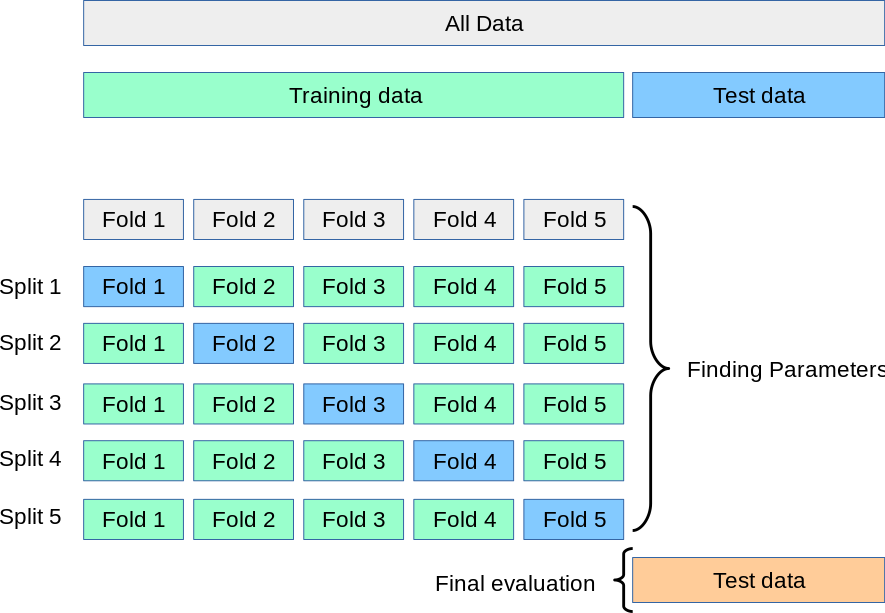

In [10]:
Image(filename='cross_validation.png',height=700,width=500)

In [0]:
#Validation function

def cross_val(model):
    kf = KFold(5, shuffle=True).get_n_splits(x_train.values)
    rmse= root_mean_squared_error(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
#Base models
#LASSO Regression :
#In order to make model more Robust to outliers method RobustScaler() can be used as part of the prerpocessing
 
kfolds = KFold(n_splits=10, shuffle=True)
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))

#ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0009))
#Elastic Net Regression :

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005,l1_ratio=0.75,normalize=False,positive=True,precompute=True,selection='random',warm_start=False))
#Kernel Ridge Regression :
KRR = KernelRidge()
#Gradient Boosting Regression :
#With huber loss that makes it robust to outliers

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,max_depth=4, max_features='log2',min_samples_leaf=10, min_samples_split=2,loss='huber',alpha=0.8)
#XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=1100)
#LightGBM
model_lgb = lgb.LGBMRegressor()


In [2639]:
algs=[ENet,GBoost,KRR,lasso,model_lgb,model_xgb,ridge]
algs_name=['ENet','GBoost','KRR','lasso','lgb','xgb','ridge']
res_df=pd.DataFrame(columns=['algorithm name','mean','standard deviation'])
for idx,alg in enumerate(algs):
    alg_name=algs_name[idx]
    score = cross_val(alg)
    sc_mean=score.mean()
    sc_std=score.std()
    res_df=res_df.append({'algorithm name':alg_name,'mean':sc_mean,'standard deviation':sc_std},ignore_index=True)
    score = cross_val(alg)
    print("\n"+alg_name+ "score: {:.4f} ({:.4f})\n".format(sc_mean, sc_std))


ENetscore: 0.1173 (0.0064)


GBoostscore: 0.1192 (0.0068)


KRRscore: 0.1195 (0.0064)


lassoscore: 0.1181 (0.0066)


lgbscore: 0.1284 (0.0056)

[06:46:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprec

In [2640]:
res_df.sort_values(by='mean')

,algorithm name,mean,standard deviation
6,ridge,0.117246,0.006192
0,ENet,0.117291,0.006418
3,lasso,0.118083,0.006550
1,GBoost,0.119196,0.006757
2,KRR,0.119543,0.006426
5,xgb,0.124191,0.004519
4,lgb,0.128375,0.005645


In [2641]:
ENet.fit(x_train,y_train)
GBoost.fit(x_train,y_train)
KRR.fit(x_train,y_train)
lasso.fit(x_train,y_train)
model_xgb.fit(x_train,y_train)
model_lgb.fit(x_train,y_train)
ridge.fit(x_train,y_train)

[06:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                         cv=KFold(n_splits=10, random_state=None, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)

In [0]:
y1 = ENet.predict(test_data)
y2 = GBoost.predict(test_data)
y3 = KRR.predict(test_data)
y4 = lasso.predict(test_data)
y5 = model_lgb.predict(test_data)
y6 = ridge.predict(test_data)
y7 = model_xgb.predict(test_data)

In [0]:
from mlxtend.regressor import StackingCVRegressor
stacking_reg = StackingCVRegressor(regressors=(ridge, lasso, ENet, GBoost),
                                meta_regressor=ENet,
                                use_features_in_secondary=True)
stacking_reg.fit(np.array(x_train),np.array(y_train))
sr=stacking_reg.predict(np.array(test_data))

In [2644]:
################################################################################
#FINAL PREDICTIONS
y_pred = y2*0.1+y4*0.1+y6*0.15+y7*0.25+sr*0.4 


y_pred = np.exp(y_pred)
print(y_pred[:5])#first five

[118137.30027457 155029.32523903 181514.4685513  193817.04839733
 194597.54201867]


In [0]:
#how it looks on the training
x1 = ENet.predict(x_train)
x2 = GBoost.predict(x_train)
x3 = KRR.predict(x_train)
x4 = lasso.predict(x_train)
x5 = model_lgb.predict(x_train)
x6 = ridge.predict(x_train)
x7 = model_xgb.predict(x_train)
sr_x=stacking_reg.predict(np.array(x_train))

In [0]:
y_train=np.exp(y_train)

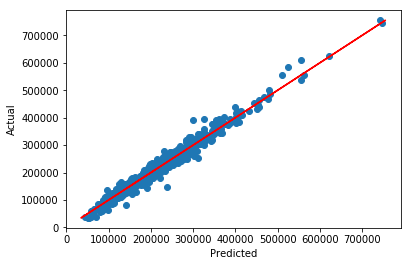

In [2647]:
x_pred=np.exp(x2*0.1+x4*0.1+x6*0.15+x7*0.25+sr_x*0.4)#using the weighted predictions+stacking

fig, ax = plt.subplots()
plt.scatter(x_pred,y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot(y_train,y_train,color='red')

In [0]:
submission=pd.DataFrame()
submission['Id']=Id
submission['SalePrice']=y_pred

In [0]:
submission.to_csv('submission.csv',index=False)#storing to the submission file

In [2650]:
submission.head()

,Id,SalePrice
0,1461,118137.300275
1,1462,155029.325239
2,1463,181514.468551
3,1464,193817.048397
4,1465,194597.542019


In [0]:
#test of the models again to show how the models were chosen
y=train_data.SalePrice
x=train_data.drop(['SalePrice'],axis=1)
x_train2, x_test2, y_train2, y_test2=train_test_split(x,y,test_size=.2)

In [2652]:
ENet.fit(x_train2,y_train2)
GBoost.fit(x_train2,y_train2)
KRR.fit(x_train2,y_train2)
lasso.fit(x_train2,y_train2)
model_xgb.fit(x_train2,y_train2)
model_lgb.fit(x_train2,y_train2)
ridge.fit(x_train2,y_train2)

[06:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                         cv=KFold(n_splits=10, random_state=None, shuffle=True),
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=False))],
         verbose=False)

In [0]:
train_error1 = ENet.predict(x_train2)
train_error2 = GBoost.predict(x_train2)
train_error3 = KRR.predict(x_train2)
train_error4 = lasso.predict(x_train2)
train_error5 = model_lgb.predict(x_train2)
train_error6 = ridge.predict(x_train2)
train_error7 = model_xgb.predict(x_train2)

In [0]:
#Cross-Validation function
def cross_val_rmse(model,x,y):
    kf = KFold(5, shuffle=True).get_n_splits(x.values)
    rmse= root_mean_squared_error(-cross_val_score(model, x.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(round(np.mean(rmse),3))

In [2655]:
#train error
train_df=pd.DataFrame()
for idx,alg in enumerate(algs):
  alg_name=algs_name[idx]
  rmse=cross_val_rmse(algs[idx],x_train2,y_train2)
  train_df=train_df.append({'algorithm name':alg_name,'rmse_train':rmse},ignore_index=True)
#test error
test_df=pd.DataFrame()
for idx,alg in enumerate(algs):
  alg_name=algs_name[idx]
  rmse=cross_val_rmse(algs[idx],x_test2,y_test2)
  test_df=test_df.append({'algorithm name':alg_name,'rmse_test':rmse},ignore_index=True)

[06:48:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [2656]:
pd.merge(train_df,test_df).sort_values(by=['rmse_test','rmse_train'])

,algorithm name,rmse_train,rmse_test
6,ridge,0.115,0.139
3,lasso,0.117,0.141
1,GBoost,0.120,0.141
0,ENet,0.117,0.142
4,lgb,0.129,0.151
2,KRR,0.118,0.154
5,xgb,0.124,0.158


       Ridge, Lasso, ElasticNet and GradientBoosting have the smallest rmse value. That was the reason they were put in the StackingCVRegressors in the following way:        
        ◦ regressors = (Ridge, Lasso, ElasticNet, GradientBoosting)
        ◦ meta_regressor=ENet-since it performed the best
        
Final predictions were made as a weighted combinations of regressors and stacking as mentioned above.



## How Optimization was done?

Optimization of hyperparameters was done by using **RandomizedSearchCV** method from *sklearn.model_selection* library which as an input receives the following:

   - **estimator** we are evaluating (chosen algorithm)
   - **param_distributions** chosen values for testing the parameters
   - **n_iter** number of iterations 
   - **scoring** is a chosen scoring function for evaluating algorithm performance
   - **cv**=5


We are putting it as a comment so we don't reexecute it again since we chose hyperparameters thanks to the **RandomizedSearchCV** method.

In [0]:
## Optimization

In [2658]:
### 
'''

GradientBoostingRegressor().get_params()

#OPTIMIZING GradientBoostingRegressor()


estimator=GradientBoostingRegressor()
param_distributions={
    'n_estimators':[500,1000,2000,3000,2500,3500],#default 100
    'learning_rate':[0.05,0.1,0.3,0.2,0.4,0.6],#0.1
    'max_depth':[3,4,5,6,7],#3
    'max_features':['auto','sqrt','log2'],#None
    'min_samples_leaf':[1,10,15,20],#1
    'loss':['huber','ls','quantile'],#ls
    'min_samples_split':[2,10,20,5],#2
    'alpha':[0.5,0.8,0.9]#0.9
}
searchCV = RandomizedSearchCV(estimator, param_distributions, n_iter=45, scoring='r2',cv=10)

searchCV.fit(x_train,y_train)
searchCV.best_params_
'''

'''
GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='log2',
                                   min_samples_leaf=10, min_samples_split=2, 
                                   loss='huber',alpha=0.8)
'''

"\nGradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,\n                                   max_depth=4, max_features='log2',\n                                   min_samples_leaf=10, min_samples_split=2, \n                                   loss='huber',alpha=0.8)\n"

In [2659]:
'''

R^2 (coefficient of determination) regression score function.

#OPTIMIZING ENet()
#from surprise.model_selection import RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

estimator =  ElasticNet()
param_distributions={
    'alpha':[0.0005,0.009,0.001,0.05,0.1,0.3,0.2,0.4,0.6,0.8,0.0008,0.008,0.05,0.005,0.006],#1.0
    'l1_ratio':[0.0,0.25,0.5,0.75,1.0],#0.5 comb of L1 and L2 ratio
    'normalize':[True,False],#False
    'positive':[True,False],#False
    'precompute':[True,False],#False
    'warm_start':[True,False],#False
    'selection':['cyclic','random']
}
searchCV = RandomizedSearchCV(estimator, param_distributions, n_iter=35, scoring='neg_mean_squared_error',cv=5)

searchCV.fit(x_train,y_train)
searchCV.best_params_
'''


"\n\nR^2 (coefficient of determination) regression score function.\n\n#OPTIMIZING ENet()\n#from surprise.model_selection import RandomizedSearchCV\n\nfrom sklearn.model_selection import RandomizedSearchCV\n\nestimator =  ElasticNet()\nparam_distributions={\n    'alpha':[0.0005,0.009,0.001,0.05,0.1,0.3,0.2,0.4,0.6,0.8,0.0008,0.008,0.05,0.005,0.006],#1.0\n    'l1_ratio':[0.0,0.25,0.5,0.75,1.0],#0.5 comb of L1 and L2 ratio\n    'normalize':[True,False],#False\n    'positive':[True,False],#False\n    'precompute':[True,False],#False\n    'warm_start':[True,False],#False\n    'selection':['cyclic','random']\n}\nsearchCV = RandomizedSearchCV(estimator, param_distributions, n_iter=35, scoring='neg_mean_squared_error',cv=5)\n\nsearchCV.fit(x_train,y_train)\nsearchCV.best_params_\n"

        
    This notebook used some of the ideas from the notebooks from kaggle.com, but code was not copied -->
    only idea was referenced.

    Moreover, it is also done with help of a various online resources.

    Sincerely,
    "DuBaI group"
        Dusica Stepic
        Omirbanu Nurassilova
        Ivana Nastasic
